> From the PO.DAAC Cookbook, to access the original GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/SearchDownload_SWOTviaCMR.ipynb).

Altered version by Ben Kraas

Original version by Cassandra Nickles, PO.DAAC

# Search and Download SWOT Data via `earthaccess`

## Summary
This notebook will find and download pre-validated SWOT hydrology data (v2.0) programmatically via earthaccess python library. For more information about earthaccess visit: https://nsidc.github.io/earthaccess/

## Requirements

- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine
- **Earthdata Login**: An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

In [1]:
# Standard library imports
from datetime import datetime
import json
from pathlib import Path
import os
import glob
import zipfile

# Third-party library imports
import geopandas as gpd
import pandas as pd
import contextily as ctx
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import earthaccess

# Matplotlib inline magic command
%matplotlib inline

/home/ben/miniconda3/envs/SWOT_2024/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

## Search for SWOT data links
We want to find the SWOT files for a particular pass over North America. 

Each dataset has it's own unique shortname, which can be used to search earthaccess. Shortnames can be found on dataset landing pages or [Earthdata Search](https://search.earthdata.nasa.gov/search) Collections.

### SWOT Level 2 KaRIn High Rate Version 2.0 Datasets:

- **Water Mask Pixel Cloud NetCDF** - SWOT_L2_HR_PIXC_2.0
- **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0
- **River Vector Shapefile** - SWOT_L2_HR_RiverSP_2.0
- **Lake Vector Shapefile** - SWOT_L2_HR_LakeSP_2.0
- **Raster NetCDF** - SWOT_L2_HR_Raster_2.0

This notebook can easily be adapted by changing the following variables:

In [9]:
# setup directories and files
data_dir = Path('data')
sampling_points_shapefile = Path("res") / "Reservoirs.shp"
water_mask_pixel_cloud_dir = data_dir / 'Water mask pixel cloud'
# lake_vector_shapefile_dir = data_dir / 'lake_vector_shapefiles'

# setup scope
temporal_range = (datetime(2024, 2, 1), datetime(2024, 2, 29))
product_short_name = 'SWOT_L2_HR_PIXC_2.0'

# write to config.json
config = {
    'data_dir': str(data_dir),
    'sampling_points_shapefile': str(sampling_points_shapefile),
    'water_mask_pixel_cloud_dir': str(water_mask_pixel_cloud_dir),
    'temporal_range': (temporal_range[0].isoformat(), temporal_range[1].isoformat()),
    'product_short_name': str(product_short_name),
}
with open('config.json', 'w') as f:
    f.write(json.dumps(config, indent=4))


---
# Code section

In [4]:
# authenticate with Earthdata Login
auth = earthaccess.login()
# REVIEW: At some point, a token-based authentication is planned to be implemented by the earthaccess team:
# See: https://github.com/nsidc/earthaccess/issues/484

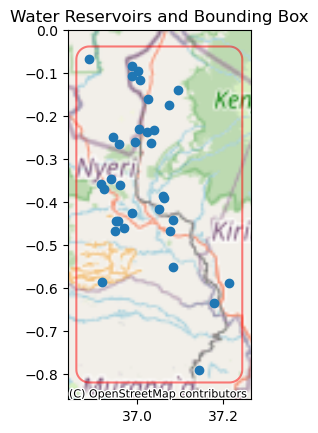

In [21]:
# get the bounding box of the reservoirs
water_reservoirs = gpd.read_file(sampling_points_shapefile)
water_reservoirs = water_reservoirs.to_crs(epsg=4326)
bbox_gdf = gpd.GeoDataFrame(geometry=[water_reservoirs.geometry.union_all().envelope])

# add a buffer to the bounding box to make sure the reservoirs are fully covered. value of 0.03 is arbitrary!
bbox_gdf['geometry'] = bbox_gdf.buffer(0.03)
bbox = bbox_gdf.geometry.union_all().bounds

# plot the bounding box and the reservoirs
ax = water_reservoirs.plot()
bbox_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, zoom=8, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326') # Default Zoom Level: 10
ax.set_title('Water Reservoirs and Bounding Box')
ax.set_aspect('equal')
ax.figure.show()

### Download the files
Search for SWOT data in the bounding box region and download it to the datasets directory

In [6]:
def unzip_files(directory):
    for zip_file in list(directory.glob('*.zip')):
         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
             zip_ref.extractall(directory)

def download_swot_data(product_short_name, temporal_range, bbox, data_dir):
    """
    Downloads SWOT data from the Earthdata API.
    
    Parameters:
        product_short_name (str): The short name of the SWOT product to download.
        temporal_range (tuple): The temporal range of the data to download.
        bbox (tuple): The bounding box of the region to download the data from.
        data_dir (Path): The directory to download the data to.
        
    Returns:
        None
    """
    if data_dir.exists() and len(list(data_dir.glob('*.zip'))) > 0:
        print(f"Found {len(list(data_dir.glob('*.zip')))} existing files in {data_dir}. Skipping download.")
    else:
        print(f"Downloading SWOT data for {product_short_name}...")
        results = earthaccess.search_data(short_name = product_short_name,
                                        temporal = (temporal_range[0].isoformat(), temporal_range[1].isoformat()),
                                        bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3]))
        print(f"Found {len(results)} pixel cloud files in the region.")
        earthaccess.download(results, data_dir)

# # ---------
# # This code may not be necessary as the vector data is quite useless... It can be uncommented for testing purposes.
# 
# download_swot_data("SWOT_L2_HR_RiverSP_2.0", temporal_range, bbox, lake_vector_shapefile_dir)
# unzip_files(lake_vector_shapefile_dir)
# 
# # ---------


# Download the pixel cloud data
download_swot_data(product_short_name, temporal_range, bbox, water_mask_pixel_cloud_dir)

Found 9 pixel cloud files in the region.


QUEUEING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 4972.83it/s]
PROCESSING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 73728.00it/s]
COLLECTING RESULTS | : 100%|██████████| 9/9 [00:00<00:00, 102578.09it/s]


# Processing
So far, this is what I (BK) have interpreted from my understanding of the SWOT data, the data that is available and the task at hand.


## First approach [DEPRECATED]: 
EDIT: This approach is not feasible - the vector files are too rough to be used for this purpose. A different approach will be needed.
With both the pixel cloud and vector attribute files, we can 
1. Identify the lake vectors that contain a sample point
2. Clip the pixel cloud using the lake vectors
3. Aggregate the pixel cloud values over the lake vectors
4. Calculate the lake water level from the aggregated pixel cloud values

## Modified approach [PROPOSED BY BK, PENDING APPROVAL]:
1. Verify that in close proximity to each sampling point, there are pixel cloud points (within a certain distance threshold)
    - A flag may need to be set to indicate that a pixel cloud point is or is not within the distance threshold to identify if in proximity to a sampling point corresponding values could be found.
2. Get the nearest pixel cloud point to each sampling point and then determine a cloud cluster around each sampling point walking through the pixel cloud points at a certain distance threshold
3. This cluster could be structured by a list of pixel cloud points that are within the distance threshold of the sampling point 
4. The resulting dataframe can either be structured using a multi-index structure, dataframe nesting (temporally or spatially) or a concatenated single dataframe containing both datetime and cluster id.

In [9]:
# open the first file in the pixel cloud directory for inspection
filepath = list(water_mask_pixel_cloud_dir.glob('*.nc'))[0]

# look into the "pixel_cloud" group
ds = xr.open_dataset(filepath, group='pixel_cloud')
ds

<xarray.Dataset> Size: 1GB
Dimensions:                                (points: 4801288, complex_depth: 2,
                                            num_pixc_lines: 3284)
Coordinates:
    latitude                               (points) float64 38MB ...
    longitude                              (points) float64 38MB ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 38MB ...
    range_index                            (points) float64 38MB ...
    interferogram                          (points, complex_depth) float32 38MB ...
    power_plus_y                           (points) float32 19MB ...
    power_minus_y                          (points) float32 19MB ...
    coherent_power                         (points) float32 19MB ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB ...
    data_window_first_valid                (num_pixc_lines) float64 26kB ...
    data_window_last_valid                 (num_pixc_lines) float64 26kB ...
    data_window_first_cross_track          (num_pixc_lines) float32 13kB ...
    data_window_last_cross_track           (num_pixc_lines) float32 13kB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3284
    interferogram_size_range:    7958
    looks_to_efflooks:           1.5543925643838978
    num_azimuth_looks:           7.0
    azimuth_offset:              3